## Notebook to show posts creation trends for tag

### Description
This notebook shows top trending tags and progress, based on aggregations done in the previous notebook.
Top trending tags are defined as tags which `TagShare` share increased the most for the observation period, e.g. 3 years. 

### Input
This notebook takes as an input `posts_creation_trends.csv` file, produced by the previous step.

### Output
This notebook does not produce any files. 

### Setup

In [1]:
import pandas as pd

from datetime import datetime
from dateutil.relativedelta import relativedelta
import plotly.graph_objects as go
import plotly.io as pio

from config import get_file_path

pio.renderers.default = 'notebook_connected' # To make possible render charts inside Jupyter

In [2]:
# Utility function for working with year-month operations
def subtract_months(year_month: str, month_count: int) -> str:
    date = datetime.strptime(year_month, "%Y-%m")
    new_date = date - relativedelta(months=month_count)
    return new_date.strftime("%Y-%m")

def past_years_dates(year_month: str, years: int) -> list[str]:
    months = range(0, years * 12 + 1)
    return list([subtract_months(year_month, month) for month in months])

In [3]:
posts_creation_trends_path = get_file_path('posts_creation_trends.csv')
posts_creation_trends_df = pd.read_csv(posts_creation_trends_path)
posts_creation_trends_df

,Tag,CreationDate,TagPostsCreated,TagTotalPostsCreated,PostsCreated,TotalPostsCreated,TagShare,TagRank
0,.a,2010-01,4,4.0,145866,1560787.0,0.000256,9138.0
1,.a,2010-03,2,6.0,160711,1862493.0,0.000322,9492.0
2,.a,2010-04,5,11.0,150604,2013097.0,0.000546,8539.0
3,.a,2011-02,1,12.0,236699,3929356.0,0.000305,11605.0
4,.a,2011-05,4,16.0,281657,4772127.0,0.000335,12028.0
...,...,...,...,...,...,...,...,...
3650769,zyte,2023-06,2,28.0,161929,55801992.0,0.000050,20477.0
3650770,zyte,2023-09,1,29.0,135820,56252733.0,0.000052,19279.0
3650771,zyte,2023-12,3,32.0,110803,56630812.0,0.000057,18069.0
3650772,zyte,2024-01,1,33.0,125348,56756160.0,0.000058,18929.0


### Calculate delta for tag share and tag rank for observation period

In [4]:
def delta_by(df, source_column: str, multiplier: int = 1):
    start_column = f'Start{source_column}'
    end_column = f'End{source_column}'
    
    def extract_first_last(x):
        return pd.Series([x.iloc[0], x.iloc[-1]], index=[start_column, end_column])

    delta_df = df.\
        groupby('Tag')[source_column].\
        apply(extract_first_last).\
        unstack()
    
    delta_df[f'{source_column}Delta'] = multiplier * (delta_df[end_column] - delta_df[start_column])
    return delta_df

In [5]:
observation_period_years = 5
start_date = posts_creation_trends_df["CreationDate"].max()
dates = past_years_dates(start_date, observation_period_years)

print(f'Start date: {start_date}')
print(f'Dates: {dates}')

Start date: 2024-03
Dates: ['2024-03', '2024-02', '2024-01', '2023-12', '2023-11', '2023-10', '2023-09', '2023-08', '2023-07', '2023-06', '2023-05', '2023-04', '2023-03', '2023-02', '2023-01', '2022-12', '2022-11', '2022-10', '2022-09', '2022-08', '2022-07', '2022-06', '2022-05', '2022-04', '2022-03', '2022-02', '2022-01', '2021-12', '2021-11', '2021-10', '2021-09', '2021-08', '2021-07', '2021-06', '2021-05', '2021-04', '2021-03', '2021-02', '2021-01', '2020-12', '2020-11', '2020-10', '2020-09', '2020-08', '2020-07', '2020-06', '2020-05', '2020-04', '2020-03', '2020-02', '2020-01', '2019-12', '2019-11', '2019-10', '2019-09', '2019-08', '2019-07', '2019-06', '2019-05', '2019-04', '2019-03']


In [6]:
latest_posts_creation_trends_df = posts_creation_trends_df[posts_creation_trends_df["CreationDate"].isin(dates)]

tag_share_delta_df = delta_by(latest_posts_creation_trends_df, 'TagShare')
tag_rank_delta_df = delta_by(latest_posts_creation_trends_df, 'TagRank', -1) # Multiply delta by -1 because rank value increase has opposite meaning then in other metric cases

latest_tags_trends_delta_df =  tag_share_delta_df. \
    merge(tag_rank_delta_df, on='Tag', how='inner'). \
    reset_index()
latest_tags_trends_delta_df

,Tag,StartTagShare,EndTagShare,TagShareDelta,StartTagRank,EndTagRank,TagRankDelta
0,.a,0.000531,0.000517,-0.000014,14039.0,13030.0,1009.0
1,.app,0.000646,0.000607,-0.000039,13129.0,12368.0,761.0
2,.aspxauth,0.000280,0.000251,-0.000029,16555.0,15663.0,892.0
3,.class-file,0.001419,0.001245,-0.000174,9369.0,9072.0,297.0
4,.csproj.in,0.000006,0.000007,0.000001,22542.0,20729.0,1813.0
...,...,...,...,...,...,...,...
58800,zynq,0.000893,0.000960,0.000066,11657.0,10422.0,1235.0
58801,zynq-ultrascale+,0.000002,0.000039,0.000037,23508.0,19499.0,4009.0
58802,zynqmp,0.000004,0.000004,0.000000,21225.0,21225.0,-0.0
58803,zypper,0.000182,0.000242,0.000060,17832.0,14934.0,2898.0


### Find top trending tags

In [7]:
top_tags_trends_count = 10
top_tags_trends_delta_df = latest_tags_trends_delta_df.sort_values(by='TagShareDelta', ascending=False)[0:top_tags_trends_count]
top_tags_trends_delta_df

,Tag,StartTagShare,EndTagShare,TagShareDelta,StartTagRank,EndTagRank,TagRankDelta
40645,python,6.403296,8.791346,2.388049,6.0,2.0,4.0
42746,reactjs,0.673099,1.837863,1.164764,49.0,16.0,33.0
17997,flutter,0.062453,0.696752,0.634299,587.0,48.0,539.0
37089,pandas,0.550680,1.156136,0.605455,58.0,30.0,28.0
40666,python-3.x,0.759068,1.309675,0.550607,42.0,26.0,16.0
53330,typescript,0.411531,0.886579,0.475048,78.0,39.0,39.0
41669,r,1.448579,1.915310,0.466731,22.0,15.0,7.0
34220,node.js,1.359120,1.798776,0.439656,26.0,18.0,8.0
2337,angular,0.816710,1.205618,0.388908,38.0,29.0,9.0
11990,dataframe,0.272371,0.600371,0.328000,129.0,57.0,72.0


In [11]:
top_trending_tags = list(top_tags_trends_delta_df['Tag'])

months = 12 * observation_period_years
tag_trends_timeline_df = posts_creation_trends_df[posts_creation_trends_df['Tag'].isin(top_trending_tags)].\
    groupby('Tag').\
    agg(
        {
            'TagShare': lambda x: list(x)[-months:],
            'TagRank': lambda x: list(x)[-months:],
            'CreationDate': lambda x: list(x)[-months:]
        }
    ).\
    reset_index()

## Show charts for top trending tags

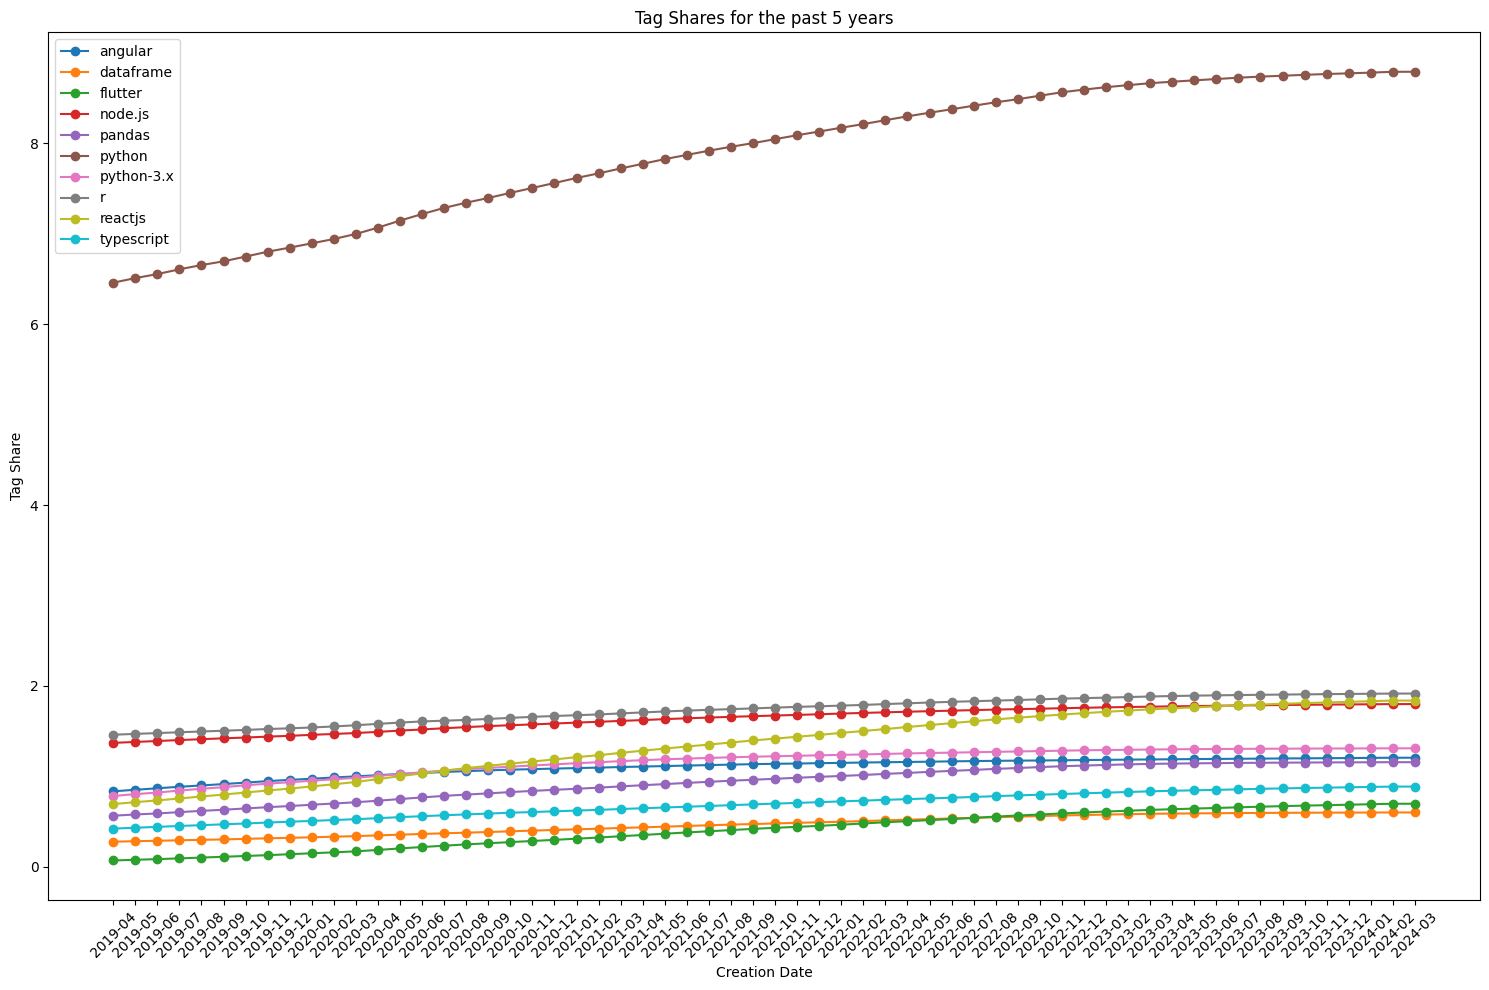

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))

for index, row in tag_trends_timeline_df.iterrows():
    ax.plot(row['CreationDate'], row['TagShare'], label=row['Tag'], marker='o')

ax.set_xlabel('Creation Date')
ax.set_ylabel('Tag Share')
ax.set_title(f'Tag Shares for the past {observation_period_years} years')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

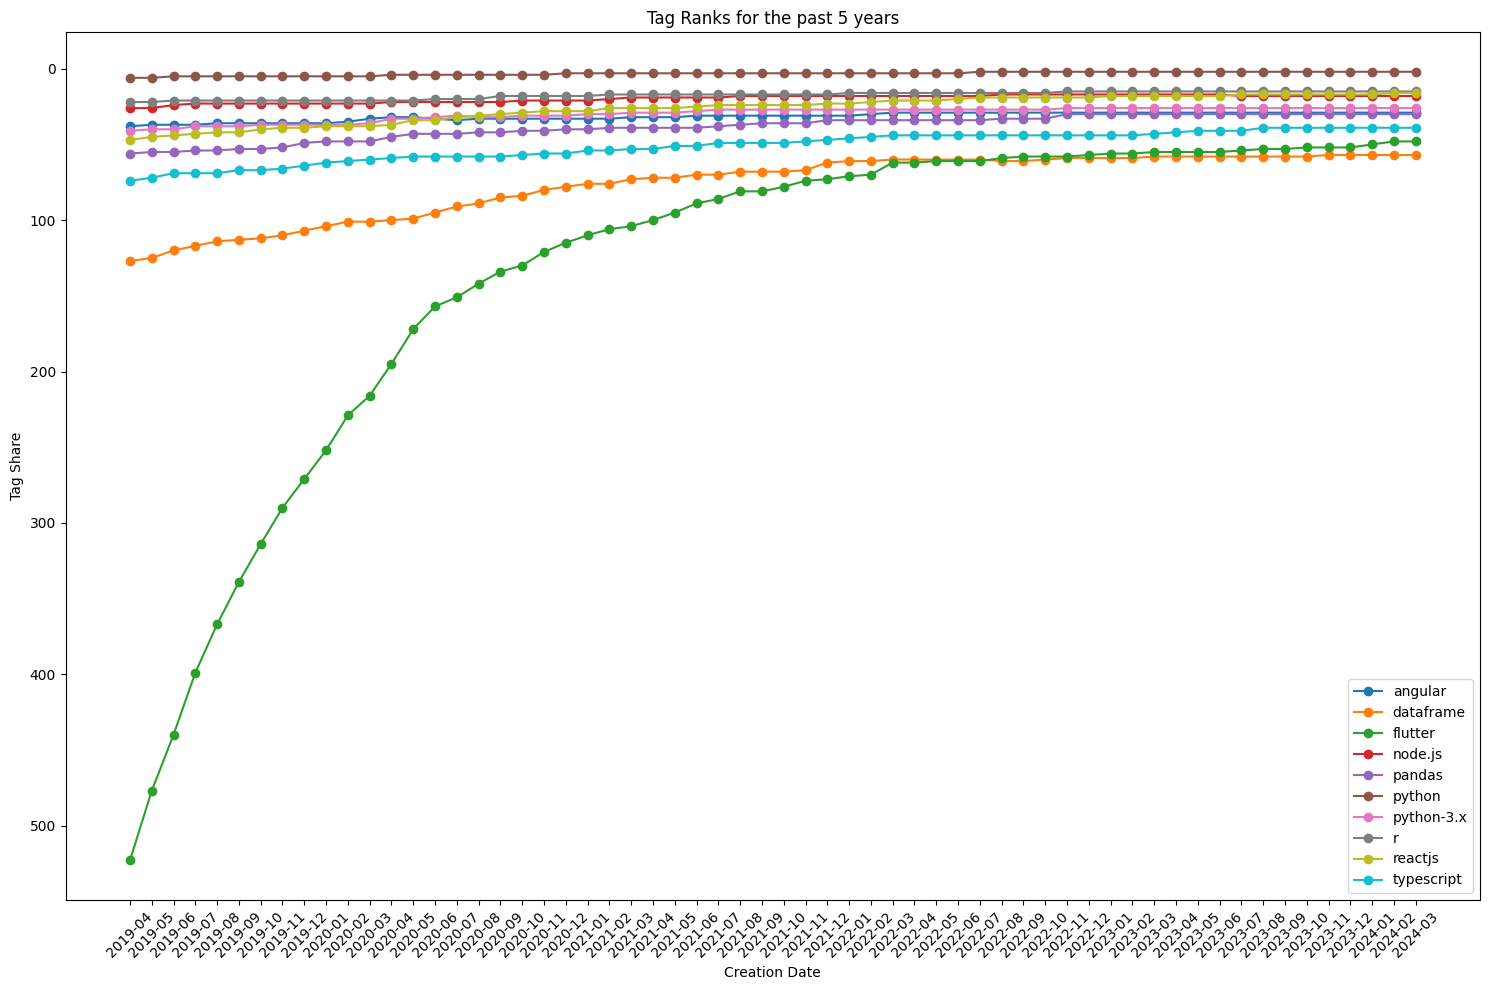

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))

for index, row in tag_trends_timeline_df.iterrows():
    ax.plot(row['CreationDate'], row['TagRank'], label=row['Tag'], marker='o')

ax.set_xlabel('Creation Date')
ax.set_ylabel('Tag Share')
ax.set_title(f'Tag Ranks for the past {observation_period_years} years')
ax.legend()

ax.invert_yaxis()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()